# 💡 **Explore and evaluate different machine learning algorithms for Android malware detection**

This suggests a comparative study of various ML algorithms to determine which are most effective for this specific application.

### Comparative Study of ML Algorithms

- Train various machine learning models like logistic regression, support vector machines, decision trees, random forests, gradient boosting machines, and neural networks on your dataset.
- Use cross-validation to evaluate their performance metrics (accuracy, precision, recall, F1 score, ROC-AUC, etc.).
- Perform statistical tests to determine if differences in performance are significant.


## 1. Data Preparation


### 1.1 Define Load Dataset Functions


In [1]:
import json
import pickle
import numpy as np

from sklearn.feature_extraction import DictVectorizer


def load_X(dataset_path, reduced=False):
    print("Loading data (feature representation X, and feature names)...")
    # Load the reduced 10k features
    if reduced:
        with open("{}/X-10k.p".format(dataset_path), "rb") as f:
            X = pickle.load(f)
        with open("{}/f-10k.p".format(dataset_path), "rb") as f:
            feature_names = pickle.load(f)
    else:
        with open("{}/X.json".format(dataset_path), "r") as f:
            X = json.load(f)

        # Convert to numpy array and get feature names
        vec = DictVectorizer()
        X = vec.fit_transform(X).astype("float32")
        feature_names = vec.get_feature_names_out()

    return X, feature_names


def load_y(dataset_path):
    print("Loading labels...")
    with open("{}y.json".format(dataset_path), "rt") as f:
        y = json.load(f)
    y = np.asarray(y)
    return y


def load_metadata(dataset_path):
    print("Loading metadata...")
    with open("{}meta.json".format(dataset_path), "rt") as f:
        metadata = json.load(f)
    return metadata

### 1.2 Load Dataset and Metadata


In [2]:
# Set the path to the dataset
dataset_path = "./extended-features/"

# Load the data
X, feature_names = load_X(dataset_path, reduced=True)
y = load_y(dataset_path)
metadata = load_metadata(dataset_path)

Loading data (feature representation X, and feature names)...
Loading labels...
Loading metadata...


### ⭐️ 1.3 Apply Feature Selection

- Focused on "api_calls:: ~ " features
- Full Dataset: X_full, y_full
- Filtered Dataset: X_filtered, y_filtered


In [3]:
def apply_feature_selection(X, y, feature_names, interest="api_calls::"):
    print("Class distribution before filtering:")
    print(np.unique(y, return_counts=True))

    selected_indices = [
        i
        for i, feature_name in enumerate(feature_names)
        if feature_name.startswith(interest)
    ]

    # Select feature names based on the selected indices
    selected_feature_names = [feature_names[i] for i in selected_indices]

    # Select data with the selected features
    X_filtered = X[:, selected_indices]

    print(f"\n ✅ Selected Features: {len(selected_indices)}")
    for name in selected_feature_names[:5]:
        print(f"    🔹 {name}")
    print(f"    ...")

    # Check if each sample (row) has at least one selected feature
    selected_rows = np.where(X_filtered.sum(axis=1) > 0)[0]

    # Indices of samples that do not contain any of the selected features
    removed_rows = np.setdiff1d(np.arange(X.shape[0]), selected_rows)

    # Shape of the original data
    print(f"\n ✅ Original Data Shape (X): {X.shape}")

    # Shape of the data with selected features
    print(f"   - Data with Selected Features Shape: {X_filtered.shape}")

    # Number of samples that do not contain any of the selected features
    print(f"   - Number of Removed Samples: {len(removed_rows)}")

    # Shape of the data after removing samples without selected features
    X_filtered = X_filtered[selected_rows]
    y_filtered = y[selected_rows]

    print(f"   - Data Shape After Removing Samples: {X_filtered.shape}")

    if len(np.unique(y_filtered)) < 2:
        raise ValueError(
            "Filtering resulted in a single-class dataset. Adjust your filtering criteria."
        )

    print(f"\n ✅ Data Shape After Removing Samples (X_filtered): {X_filtered.shape}")

    return X_filtered, y_filtered, selected_feature_names, selected_indices


X_full, y_full = X, y  # Store full dataset
X_filtered, y_filtered, selected_feature_names, selected_indices = (
    apply_feature_selection(X_full, y_full, feature_names)
)

Class distribution before filtering:
(array([0, 1]), array([232843,  26387]))

 ✅ Selected Features: 24
    🔹 api_calls::android/content/pm/PackageManager;->setApplicationEnabledSetting
    🔹 api_calls::android/telephony/gsm/SmsManager;->sendDataMessage
    🔹 api_calls::android/provider/Settings$System;->putFloat
    🔹 api_calls::android/net/NetworkInfo;->isConnectedOrConnecting
    🔹 api_calls::android/content/Context;->sendOrderedBroadcast
    ...

 ✅ Original Data Shape (X): (259230, 10000)
   - Data with Selected Features Shape: (259230, 24)
   - Number of Removed Samples: 95057
   - Data Shape After Removing Samples: (164173, 24)

 ✅ Data Shape After Removing Samples (X_filtered): (164173, 24)


### 1.4 Dataset Study


#### 1.4.1 Compute the number of Selected Features


In [4]:
from datetime import datetime

import numpy as np


def get_quarter(date_string):
    try:
        # Try the format with 'T' first
        date = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%S")
    except ValueError:
        # If it fails, try the format with a space
        date = datetime.strptime(date_string, "%Y-%m-%d %H:%M:%S")
    return f"{date.year}-Q{(date.month-1)//3 + 1}"


# Select features that start with 'api_calls::'
interest = "api_calls::"
selected_indices = [
    i
    for i, feature_name in enumerate(feature_names)
    if feature_name.startswith(interest)
]

# Count the number of 'api_calls::' features for each sample
api_call_counts = np.sum(X[:, selected_indices] > 0, axis=1)

# Combine the counts with the labels and add an index
combined_api_data = []
for idx, (meta, count, label) in enumerate(zip(metadata, api_call_counts, y)):
    dex_date = meta["dex_date"]
    quarter = get_quarter(dex_date)
    category = "benign" if label == 0 else "malicious"
    combined_api_data.append(
        {
            "index": idx,
            "dex_date": dex_date,
            "quarter": quarter,
            "api_call_count": int(count),
            "category": category,
        }
    )

/var/folders/kh/_kvrqy8j0yq7sjnzmxrljggm0000gn/T/ipykernel_2202/2972243881.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "api_call_count": int(count),


#### 1.4.2 Dataset Statistic

##### 1.4.2.1 Tables


In [5]:
# Count occurrences for each quarter and category
from collections import defaultdict

quarterly_counts = defaultdict(lambda: {"benign": 0, "malicious": 0})

for entry in combined_api_data:
    quarterly_counts[entry["quarter"]][entry["category"]] += 1

# Print the counts
print("Quarterly counts:")
for quarter, counts in sorted(quarterly_counts.items()):
    print(f"{quarter}: Benign: {counts['benign']}, Malicious: {counts['malicious']}")

# Print a few examples of the combined data
print("\nSample of combined data with API call counts:")
for entry in combined_api_data[:5]:
    print(entry)

# Additional statistics
total_samples = len(combined_api_data)
total_benign = sum(counts["benign"] for counts in quarterly_counts.values())
total_malicious = sum(counts["malicious"] for counts in quarterly_counts.values())

print(f"\nTotal samples: {total_samples}")
print(f"Total benign: {total_benign} ({total_benign/total_samples*100:.2f}%)")
print(f"Total malicious: {total_malicious} ({total_malicious/total_samples*100:.2f}%)")

Quarterly counts:
2014-Q1: Benign: 9992, Malicious: 1026
2014-Q2: Benign: 15246, Malicious: 1818
2014-Q3: Benign: 17708, Malicious: 1970
2014-Q4: Benign: 9097, Malicious: 883
2015-Q1: Benign: 4683, Malicious: 488
2015-Q2: Benign: 5889, Malicious: 620
2015-Q3: Benign: 8365, Malicious: 901
2015-Q4: Benign: 9231, Malicious: 1056
2016-Q1: Benign: 13255, Malicious: 1455
2016-Q2: Benign: 13226, Malicious: 1342
2016-Q3: Benign: 9286, Malicious: 1064
2016-Q4: Benign: 1015, Malicious: 112
2017-Q1: Benign: 15000, Malicious: 1800
2017-Q2: Benign: 15000, Malicious: 1800
2017-Q3: Benign: 15000, Malicious: 1800
2017-Q4: Benign: 15000, Malicious: 1800
2018-Q1: Benign: 15000, Malicious: 1800
2018-Q2: Benign: 15000, Malicious: 1800
2018-Q3: Benign: 15000, Malicious: 1800
2018-Q4: Benign: 10850, Malicious: 1052

Sample of combined data with API call counts:
{'index': 0, 'dex_date': '2016-04-05T17:58:46', 'quarter': '2016-Q2', 'api_call_count': 3, 'category': 'benign'}
{'index': 1, 'dex_date': '2016-01-1

##### ⭐️ 1.4.3.2 Plots


/var/folders/kh/_kvrqy8j0yq7sjnzmxrljggm0000gn/T/ipykernel_2202/262887943.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df["Quarter"])


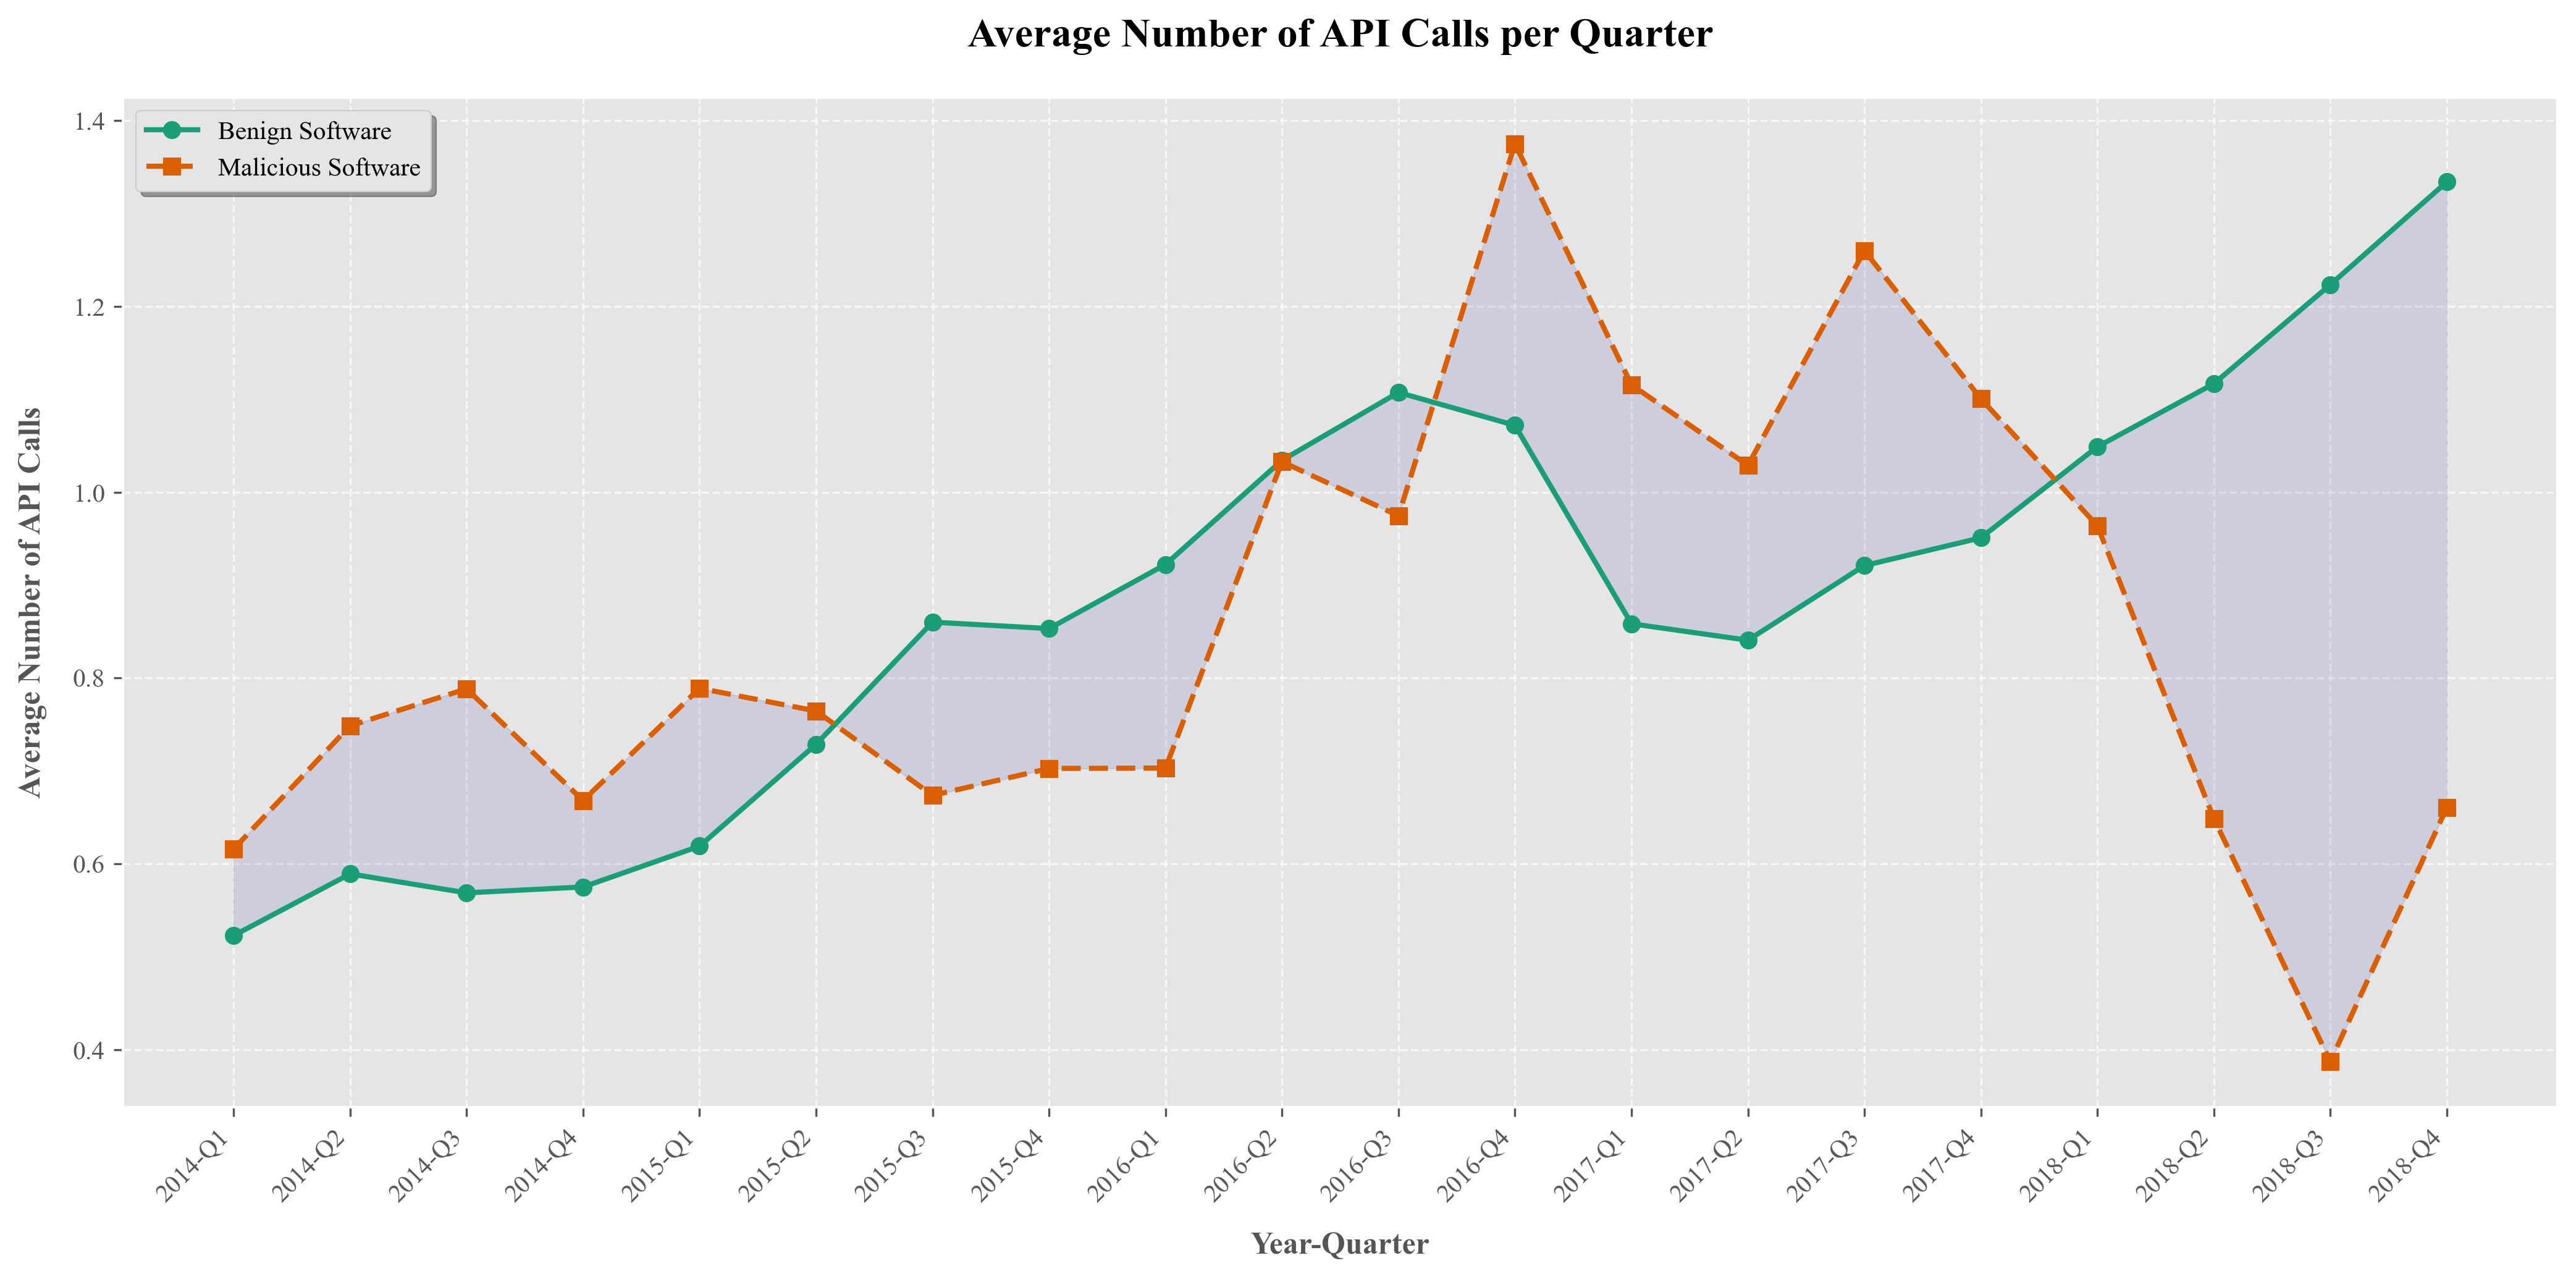

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

from collections import defaultdict

# Calculate the average number of API calls per quarter and category
quarterly_api_calls = defaultdict(lambda: {"benign": [], "malicious": []})
for entry in combined_api_data:
    quarterly_api_calls[entry["quarter"]][entry["category"]].append(
        entry["api_call_count"]
    )

# Calculate the average number of API calls per quarter and category
average_api_calls = {
    quarter: {
        "benign": np.mean(values["benign"]) if values["benign"] else 0,
        "malicious": np.mean(values["malicious"]) if values["malicious"] else 0,
    }
    for quarter, values in quarterly_api_calls.items()
}
# Sort the quarters
quarters = sorted(average_api_calls.keys())

# Assuming you have the data in the same format as before
df = pd.DataFrame(average_api_calls.items(), columns=["Quarter", "Values"])
df["Benign"] = df["Values"].apply(lambda x: x["benign"])
df["Malicious"] = df["Values"].apply(lambda x: x["malicious"])
df = df.sort_values("Quarter")

# Create a categorical x-axis
df["Quarter_Cat"] = pd.Categorical(
    df["Quarter"], categories=df["Quarter"], ordered=True
)

# Set up the plot style
plt.style.use("ggplot")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

# Plot the data
ax.plot(
    df["Quarter_Cat"],
    df["Benign"],
    color="#1b9e77",
    linewidth=2,
    marker="o",
    markersize=6,
    label="Benign Software",
)
ax.plot(
    df["Quarter_Cat"],
    df["Malicious"],
    color="#d95f02",
    linewidth=2,
    marker="s",
    markersize=6,
    label="Malicious Software",
    linestyle="--",
)

# Fill the area between the lines
ax.fill_between(
    df["Quarter_Cat"], df["Benign"], df["Malicious"], alpha=0.2, color="#7570b3"
)

# Customize the plot
ax.set_title(
    "Average Number of API Calls per Quarter", fontsize=16, fontweight="bold", pad=20
)
ax.set_xlabel("Year-Quarter", fontsize=12, fontweight="bold", labelpad=10)
ax.set_ylabel(
    "Average Number of API Calls", fontsize=12, fontweight="bold", labelpad=10
)

# Format x-axis
plt.xticks(rotation=45, ha="right")
ax.set_xticklabels(df["Quarter"])

# Ensure all x-ticks are visible
ax.set_xticks(range(len(df["Quarter"])))

# Customize grid
ax.grid(True, linestyle="--", alpha=0.7)
ax.set_axisbelow(True)

# Add legend
ax.legend(frameon=True, fancybox=True, shadow=True, fontsize=10, loc="upper left")

# Tight layout
plt.tight_layout()


# Save the figure (uncomment to save)
# plt.savefig('api_calls_per_quarter.pdf', format='pdf', dpi=300, bbox_inches='tight')
# plt.savefig('api_calls_per_quarter.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

# 💡 **Verify which feature sets are most suitable for malware classification**

This involves identifying which data attributes (features) are most predictive of malware to enhance the classifier's performance.

## Feature Suitability for Malware Classification

- Use feature selection techniques like recursive feature elimination, feature importance from tree-based models, or L1 regularization to identify which features contribute most to the predictive power of the model.
- Conduct ablation studies where you systematically remove or add feature sets to see how performance is affected.
- Compare models trained on different subsets of features (e.g., API calls only, URL features only, combined features) to identify which sets or combinations are the most predictive.


## 2. Define Model class for Classifier

- XGBoost
- LinearSVM


### 2.1 Calculate and Evaluation


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
)


def calculate_metrics(y_true, y_pred, y_scores):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "fpr": fpr,
        "tpr": tpr,
        "roc_auc": roc_auc,
        "precision_curve": precision_curve,
        "recall_curve": recall_curve,
        "average_precision": avg_precision,
    }

### ️2.2 Define and Model Class


In [8]:
from dataclasses import dataclass, field
from typing import Any
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from scipy.sparse import issparse

tscv = TimeSeriesSplit(n_splits=5)


@dataclass
class Model:
    name: str
    model: Any
    X: np.ndarray
    y: np.ndarray
    accuracy: float = field(init=False, default=None)
    precision: float = field(init=False, default=None)
    recall: float = field(init=False, default=None)
    f1: float = field(init=False, default=None)
    cm: np.ndarray = field(init=False, default=None)
    roc_auc: float = field(init=False, default=None)
    fpr: float = field(init=False, default=None)
    tpr: float = field(init=False, default=None)
    precision_curve: float = field(init=False, default=None)
    recall_curve: float = field(init=False, default=None)
    average_precision: float = field(init=False, default=None)

    pr_curves: list = field(init=False, default_factory=list)
    roc_curves: list = field(init=False, default_factory=list)
    cv_results: dict = field(init=False, default_factory=dict)

    def __str__(self):
        return self.name

    def train_and_evaluate_model(self):
        X = self.X
        y = self.y
        self.pr_curves = []
        self.roc_curves = []
        self.cv_results = {
            "accuracy": [],
            "precision": [],
            "recall": [],
            "f1": [],
            "roc_auc": [],
            "average_precision": [],
        }

        for train_index, test_index in tscv.split(X):
            X_train, X_test = self._split_data(X, train_index, test_index)
            y_train, y_test = self._split_data(y, train_index, test_index)

            self.model.fit(X_train, y_train)
            predictions = self.model.predict(X_test)
            y_scores = self.get_prediction_scores(X_test)

            metrics = calculate_metrics(y_test, predictions, y_scores)

            for key in self.cv_results:
                self.cv_results[key].append(metrics[key])

            self.pr_curves.append(
                (metrics["precision_curve"], metrics["recall_curve"], None)
            )
            self.roc_curves.append((metrics["fpr"], metrics["tpr"], metrics["roc_auc"]))

        # Calculate average metrics across all folds
        for key in self.cv_results:
            setattr(self, key, np.mean(self.cv_results[key]))

    def _split_data(self, data, train_index, test_index):
        if issparse(data):
            return data[train_index], data[test_index]
        elif isinstance(data, np.ndarray):
            return data[train_index], data[test_index]
        else:
            return data.iloc[train_index], data.iloc[test_index]

    def get_prediction_scores(self, X_test):
        if hasattr(self.model, "predict_proba"):
            return self.model.predict_proba(X_test)[:, 1]
        elif hasattr(self.model, "decision_function"):
            return self.model.decision_function(X_test)
        else:
            raise AttributeError(
                "Model has neither predict_proba nor decision_function method"
            )

    def print_result(self):
        print(f"\n   ✅ Results for {self.name} (Time Series Cross-Validation)")
        print(f"\t🔹 Average Accuracy: {self.accuracy:.4f}")
        print(f"\t🔹 Average Precision: {self.precision:.4f}")
        print(f"\t🔹 Average Recall: {self.recall:.4f}")
        print(f"\t🔹 Average F1 Score: {self.f1:.4f}")
        print(f"\t🔹 Average ROC AUC: {self.roc_auc:.4f}")
        print(f"\t🔹 Average Precision Score: {self.average_precision:.4f}")

### ⭐️ 2.3 Create and Initialise Models


In [9]:
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC


def initialize_models(X_full, y_full, X_filtered, y_filtered):
    xgb_parameters = {
        "n_estimators": 200,
        "learning_rate": 0.05,
        "max_depth": 4,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
    }
    svm_parameters = {
        "C": 1,
        "dual": True,
        "max_iter": 50000,
        "random_state": 42,
    }

    models_full = create_models(xgb_parameters, svm_parameters, X_full, y_full)
    models_filtered = create_models(
        xgb_parameters, svm_parameters, X_filtered, y_filtered
    )

    print(" ✅ models_full")
    for model in models_full:
        print(f"   - {model} (X_full, y_full)")

    print("\n ✅ models_filtered")
    for model in models_filtered:
        print(f"   - {model} (X_filtered, y_filtered)")

    return models_full, models_filtered


def create_models(xgb_parameters, svm_parameters, X, y):
    return [
        Model("XGBoost", XGBClassifier(**xgb_parameters), X, y),
        Model("Linear SVM", LinearSVC(**svm_parameters), X, y),
    ]


# Assuming X_full, y_full, X_filtered, y_filtered, and selected_feature_names are defined
models_full, models_filtered = initialize_models(X_full, y_full, X_filtered, y_filtered)

 ✅ models_full
   - XGBoost (X_full, y_full)
   - Linear SVM (X_full, y_full)

 ✅ models_filtered
   - XGBoost (X_filtered, y_filtered)
   - Linear SVM (X_filtered, y_filtered)


### 2.3 Define Plot functions

- ROC Curve
- Precision Recall Curve
- Confusion Matrix


#### 2.3.1 ROC Curve


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns


def plot_roc_curves(model, title_suffix=""):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12, 9))

    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []

    colors = plt.cm.viridis(np.linspace(0, 1, len(model.roc_curves)))

    for i, ((fpr, tpr, roc_auc), color) in enumerate(zip(model.roc_curves, colors), 1):
        ax.plot(
            fpr,
            tpr,
            lw=1.5,
            alpha=0.8,
            color=color,
            label=f"Fold {i} (AUC = {roc_auc:.3f})",
        )

        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="darkred",
        label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
        lw=2.5,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        lw=2,
        color="navy",
        alpha=0.8,
        label="Random Classifier",
    )

    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_xlabel("False Positive Rate", fontsize=14)
    ax.set_ylabel("True Positive Rate", fontsize=14)
    ax.set_title(
        f"Receiver Operating Characteristic (ROC) Curve\n{model.name} {title_suffix}",
        fontsize=16,
        fontweight="bold",
    )

    ax.legend(
        loc="lower right",
        fontsize="medium",
        frameon=True,
        fancybox=True,
        framealpha=0.8,
        edgecolor="lightgrey",
    )

    # Add zoomed inset
    axins = inset_axes(ax, width="40%", height="40%", loc="center right", borderpad=7)
    for (fpr, tpr, _), color in zip(model.roc_curves, colors):
        axins.plot(fpr, tpr, lw=1.5, alpha=0.8, color=color)
    axins.plot(mean_fpr, mean_tpr, color="darkred", lw=2.5, alpha=0.8)
    axins.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2)
    axins.set_xlim(0.0, 0.4)
    axins.set_ylim(0.6, 1.0)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    axins.set_xlabel("Zoomed in", fontsize=10)

    # Add connecting lines
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset

    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    axins.text(
        0.05,
        0.95,
        f"Average AUC = {mean_auc:.3f}",
        transform=axins.transAxes,
        fontsize=10,
        verticalalignment="top",
    )

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(
        f'{model.name.lower().replace(" ", "_")}_roc_curves{title_suffix.replace(" ", "_")}.png',
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

#### 2.3.2 Precision Recall Curve


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import numpy as np


def plot_pr_curves(model, title_suffix=""):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12, 9))

    mean_recall = np.linspace(0, 1, 100)
    precisions = []
    aucs = []

    colors = plt.cm.viridis(np.linspace(0, 1, len(model.pr_curves)))

    for i, ((precision, recall, _), color) in enumerate(
        zip(model.pr_curves, colors), 1
    ):
        ax.plot(
            recall,
            precision,
            lw=1.5,
            alpha=0.8,
            color=color,
            label=f"Fold {i} (AUC = {auc(recall, precision):.3f})",
        )

        precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
        aucs.append(auc(recall, precision))

    mean_precision = np.mean(precisions, axis=0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    ax.plot(
        mean_recall,
        mean_precision,
        color="darkred",
        label=f"Mean PR (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
        lw=2.5,
        alpha=0.8,
    )

    std_precision = np.std(precisions, axis=0)
    precision_upper = np.minimum(mean_precision + std_precision, 1)
    precision_lower = np.maximum(mean_precision - std_precision, 0)
    ax.fill_between(
        mean_recall,
        precision_lower,
        precision_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_xlabel("Recall", fontsize=14)
    ax.set_ylabel("Precision", fontsize=14)
    ax.set_title(
        f"Precision-Recall Curve\n{model.name} {title_suffix}",
        fontsize=16,
        fontweight="bold",
    )

    ax.legend(
        loc="lower left",
        fontsize="medium",
        frameon=True,
        fancybox=True,
        framealpha=0.8,
        edgecolor="lightgrey",
    )

    # Add zoomed inset
    axins = inset_axes(ax, width="40%", height="40%", loc="center left", borderpad=1)
    for (precision, recall, _), color in zip(model.pr_curves, colors):
        axins.plot(recall, precision, lw=1.5, alpha=0.8, color=color)
    axins.plot(mean_recall, mean_precision, color="darkred", lw=2.5, alpha=0.8)
    axins.fill_between(
        mean_recall, precision_lower, precision_upper, color="grey", alpha=0.2
    )
    axins.set_xlim(0.6, 1.0)
    axins.set_ylim(0.6, 1.0)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    axins.set_xlabel("Zoomed in", fontsize=10)

    # Add connecting lines
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset

    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    axins.text(
        0.05,
        0.95,
        f"Average AUC = {mean_auc:.3f}",
        transform=axins.transAxes,
        fontsize=10,
        verticalalignment="top",
    )

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(
        f'{model.name.lower().replace(" ", "_")}_pr_curves{title_suffix.replace(" ", "_")}.png',
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

#### 2.3.3 Confusion Matrix


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


def plot_confusion_matrix(model, title_suffix=""):
    # Calculate the average confusion matrix across all folds
    cm_sum = np.zeros((2, 2))  # Assuming binary classification
    for train_index, test_index in tscv.split(X):
        _, X_test = model._split_data(X, train_index, test_index)
        _, y_test = model._split_data(y, train_index, test_index)
        y_pred = model.model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        cm_sum += cm

    cm_avg = cm_sum / len(model.cv_results["accuracy"])

    # Create figure
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm_avg, annot=True, fmt=".2f", cmap="Blues", cbar=False)

    # Set labels and title
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Average Confusion Matrix\n{model.name} {title_suffix}", fontsize=14)

    # Save and show the plot
    plt.tight_layout()
    plt.savefig(
        f'{model.name.lower().replace(" ", "_")}_avg_confusion_matrix{title_suffix.replace(" ", "_")}.png',
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()


# Usage:
# plot_confusion_matrix(model, title_suffix='(full)')

### 2.3 Model Evaluation

**Model Selection**: We will evaluate the performance of the following models:

- XGBoost
- LinearSVC


#### 2.3.1 Create Models


#### ⭐️ 2.3.2 Train and Evaluate Models



   ✅ Results for XGBoost (Time Series Cross-Validation)
	🔹 Average Accuracy: 0.9575
	🔹 Average Precision: 0.8877
	🔹 Average Recall: 0.6685
	🔹 Average F1 Score: 0.7595
	🔹 Average ROC AUC: 0.9497
	🔹 Average Precision Score: 0.8395


/var/folders/kh/_kvrqy8j0yq7sjnzmxrljggm0000gn/T/ipykernel_2202/1832400911.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


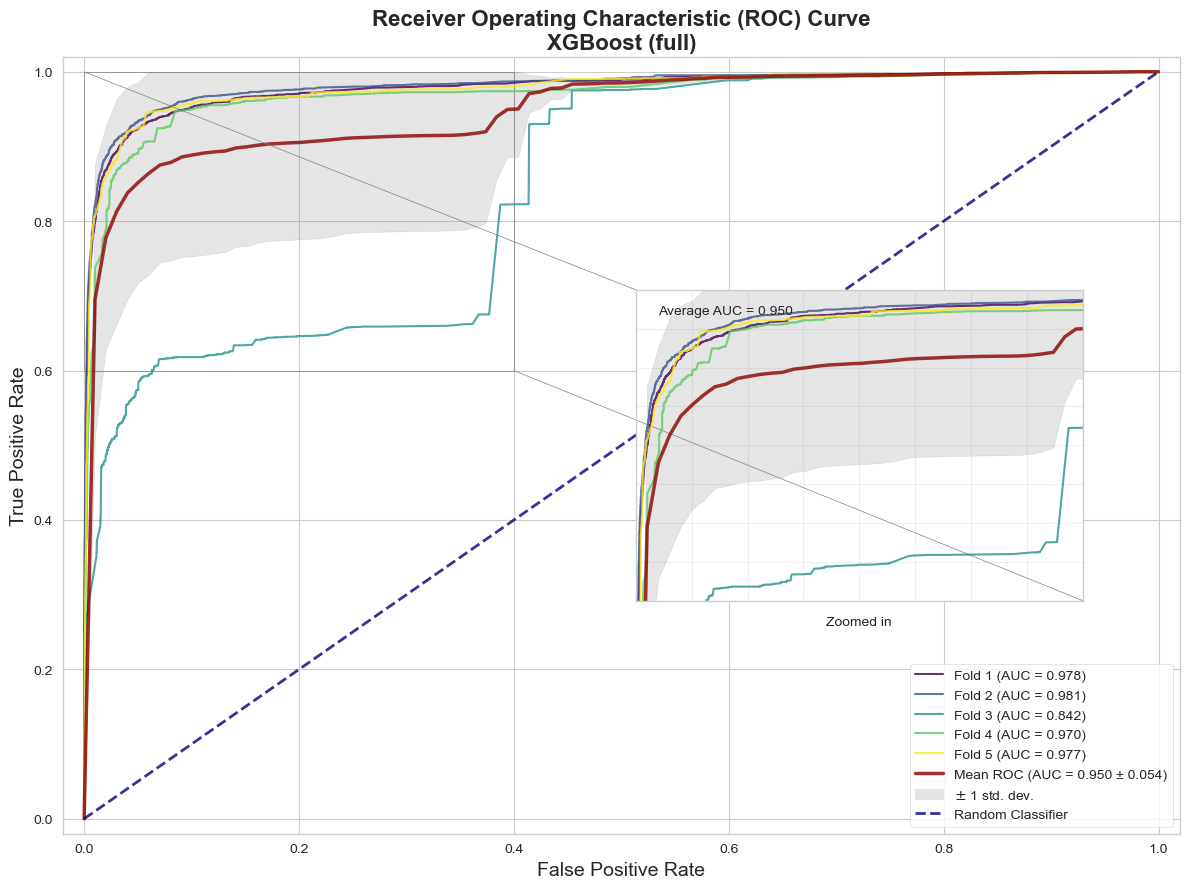


   ✅ Results for XGBoost (Time Series Cross-Validation)
	🔹 Average Accuracy: 0.9234
	🔹 Average Precision: 0.7951
	🔹 Average Recall: 0.1378
	🔹 Average F1 Score: 0.2308
	🔹 Average ROC AUC: 0.7609
	🔹 Average Precision Score: 0.3393


/var/folders/kh/_kvrqy8j0yq7sjnzmxrljggm0000gn/T/ipykernel_2202/1832400911.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


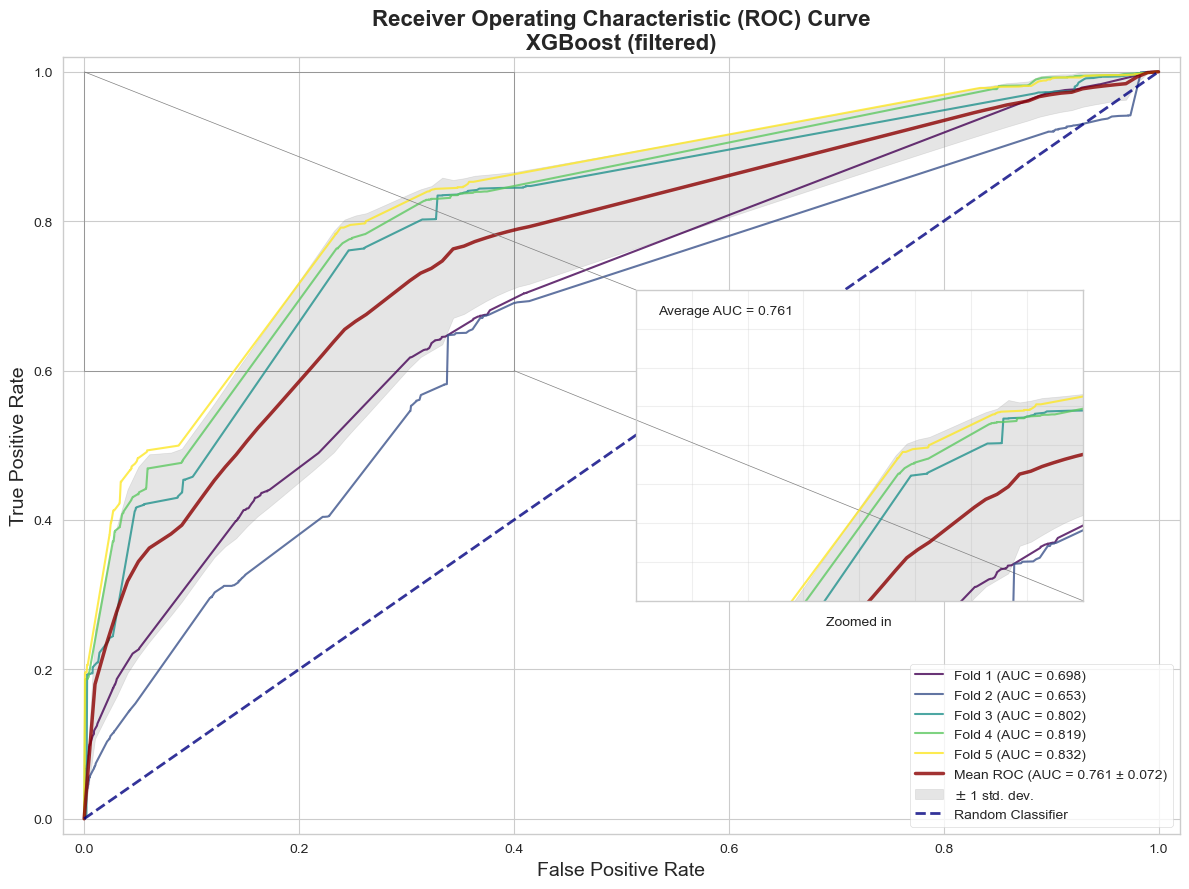

In [13]:
for model in models_full:
    if model.name == "XGBoost":
        model.train_and_evaluate_model()
        model.print_result()
        plot_roc_curves(model, title_suffix="(full)")
        # plot_pr_curves(model, title_suffix='(full)')
        # plot_confusion_matrix(model, title_suffix='(full)')
    else:
        pass

    # model.train_and_evaluate_model(X_full, y_full)
    # model.print_result()
    # plot_roc_curves(model, title_suffix='(full)')
    # plot_pr_curves(model, title_suffix='(full)')

for model in models_filtered:
    if model.name == "XGBoost":
        model.train_and_evaluate_model()
        model.print_result()
        plot_roc_curves(model, title_suffix="(filtered)")

# 💡 **Explore how explanation methods can support the design and improvement of classification algorithms**

This points to the use of explanation methods, such as SHAP, to interpret ML models' decisions, possibly to increase their transparency and trustworthiness.

This project focuses on how existing explanation methods could support a better understanding of what the classifier is learning. A known problem in the literature is indeed "shortcut learning", i.e., learning information not related to actual maliciousness. For example, a network intrusion detection algorithm may be learning that "large volumes of outgoing bytes" are an attack, but this is clearly overfitting the task. Explanations methods to be explored include (see [2]): SHAP, LIME, LEMNA, LRP.

## Use of Explanation Methods to Support Model Design:

- Apply SHAP or LIME to your models to get explanations for individual predictions, which can provide insights into what features are driving the model’s decisions for each class.
- Use global feature importance derived from SHAP to understand overall model behavior and identify which features are generally most impactful across all predictions.
- Based on the insights from SHAP, iterate on your model design, potentially simplifying models by removing less important features or engineering new features to improve clarity and performance.


### 3. Design SHAP


#### 3.1 Define Functions for SHAP Process


In [39]:
import shap
import scipy.sparse
from sklearn.preprocessing import StandardScaler

shap.initjs()


def convert_sparse_matrix_to_array(X):
    if scipy.sparse.issparse(X):
        return X.toarray()
    else:
        raise ValueError("Input is not a sparse matrix")


def scale_data_for_shap(X, selected_feature_names):
    X = convert_sparse_matrix_to_array(X)
    assert X.shape[1] == len(selected_feature_names), "Feature mismatch"

    print("\n   ✅ Feature value range:")
    print(f"\t🔹 Min: {X.min():.4f}")
    print(f"\t🔹 Max: {X.max():.4f}")
    print(f"\t🔹 Mean: {X.mean():.4f}")
    print(f"\t🔹 Std: {X.std():.4f}")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    sparsity = (X == 0).mean()
    print(f"\t🔹 Average feature sparsity: {sparsity:.2%}")

    return X_scaled


def compute_shap_values(model, X_scaled, background_sample_size=1000):
    # Create a background sample for SHAP
    background_indices = np.random.choice(
        X_scaled.shape[0], background_sample_size, replace=False
    )
    background_samples = X_scaled[background_indices]

    # Create a SHAP explainer
    explainer = shap.TreeExplainer(model.model)

    # # Create a SHAP explainer (with background samples)
    # explainer = shap.TreeExplainer(model.model, background_samples)

    # Compute SHAP values
    shap_values = explainer.shap_values(X_scaled)

    return shap_values


# Select the model to explain
model = models_filtered[0]  # XGBoost

# Train and evaluate the model
model.train_and_evaluate_model()
model.print_result()

# Scale the data for SHAP
X_scaled = scale_data_for_shap(X_filtered, selected_feature_names)

# Compute SHAP values
shap_values = compute_shap_values(model, X_scaled)


   ✅ Results for XGBoost (Time Series Cross-Validation)
	🔹 Average Accuracy: 0.9234
	🔹 Average Precision: 0.7951
	🔹 Average Recall: 0.1378
	🔹 Average F1 Score: 0.2308
	🔹 Average ROC AUC: 0.7609
	🔹 Average Precision Score: 0.3393

   ✅ Feature value range:
	🔹 Min: 0.0000
	🔹 Max: 1.0000
	🔹 Mean: 0.0584
	🔹 Std: 0.2346
	🔹 Average feature sparsity: 94.16%


#### 3.2 Define Plot functions


In [43]:
# Summary Plot
def plot_shap_summary(
    shap_values, X_scaled, feature_names, model_name, suffix="", top_n=None
):
    if top_n is not None:
        feature_importance = np.abs(shap_values).mean(0)
        top_features = feature_importance.argsort()[-top_n:]
        shap_values = shap_values[:, top_features]
        X_scaled = X_scaled[:, top_features]
        feature_names = [feature_names[i] for i in top_features]
        suffix += f" (Top {top_n} Features)"

    plt.figure(figsize=(15, 10))
    shap.summary_plot(
        shap_values,
        X_scaled,
        feature_names=feature_names,
        plot_size=(15, 10),
        show=False,
    )
    plt.title(f"SHAP Summary for {model_name} {suffix}")
    plt.tight_layout()

    filename = f'{model_name.lower().replace(" ", "_")}_shap_summary'
    if top_n is not None:
        filename += f"_top{top_n}"
    if suffix:
        filename += f'_{suffix.lower().replace(" ", "_")}'
    filename += ".png"

    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


# ! TODO: Error Handling
def plot_shap_bar_chart(shap_values, feature_names, model_name, suffix="", top_n=None):
    if top_n is not None:
        feature_importance = np.abs(shap_values).mean(0)
        top_features = feature_importance.argsort()[-top_n:]
        shap_values = shap_values[:, top_features]
        feature_names = [feature_names[i] for i in top_features]
        suffix += f" (Top {top_n} Features)"

    plt.figure(figsize=(18, 12))  # Adjust figure size for better width

    # Calculate the mean absolute SHAP values
    shap_mean = np.abs(shap_values).mean(0)

    # Sort features by importance
    indices = np.argsort(shap_mean)
    feature_names = [feature_names[i] for i in indices]
    shap_mean = shap_mean[indices]

    # Plot the bar chart manually
    y_pos = np.arange(len(feature_names))
    plt.barh(
        y_pos, shap_mean, align="center", height=0.8
    )  # Increase height for wider bars

    plt.yticks(y_pos, feature_names)
    plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
    plt.title(f"SHAP Feature Importance for {model_name} {suffix}")

    plt.tight_layout()
    plt.gca().invert_yaxis()  # Invert y-axis to match original plot order

    filename = f'{model_name.lower().replace(" ", "_")}_shap_bar_chart'
    if top_n is not None:
        filename += f"_top{top_n}"
    if suffix:
        filename += f'_{suffix.lower().replace(" ", "_")}'
    filename += ".png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


# Decision Plot
def plot_shap_decision_plot(
    shap_values,
    X_scaled,
    feature_names,
    model_name,
    suffix="",
    top_n=None,
    sample_size=50,
):
    if top_n is not None:
        feature_importance = np.abs(shap_values).mean(0)
        top_features = feature_importance.argsort()[-top_n:]
        shap_values = shap_values[:, top_features]
        X_scaled = X_scaled[:, top_features]
        feature_names = [feature_names[i] for i in top_features]
        suffix += f" (Top {top_n} Features)"

    # Select a subset of samples for visualization
    sample_indices = np.random.choice(X_scaled.shape[0], sample_size, replace=False)
    shap_values_sample = shap_values[sample_indices]
    X_scaled_sample = X_scaled[sample_indices]

    plt.figure(figsize=(15, 10))
    shap.decision_plot(
        shap_values=shap_values_sample,
        base_value=0,
        feature_names=feature_names,
        feature_order="importance",
        show=False,
    )
    plt.title(f"SHAP Decision Plot for {model_name} {suffix}")
    plt.tight_layout()

    filename = f'{model_name.lower().replace(" ", "_")}_shap_decision_plot'
    if top_n is not None:
        filename += f"_top{top_n}"
    if suffix:
        filename += f'_{suffix.lower().replace(" ", "_")}'
    filename += ".png"

    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


# Waterfall Plot
def plot_shap_waterfall(
    shap_values, X_scaled, feature_names, model_name, sample_index=0, top_n=10
):
    # Get SHAP values for a single instance
    instance_shap_values = shap_values[sample_index]

    # Sort features by absolute SHAP value
    feature_importance = np.abs(instance_shap_values)
    sorted_idx = feature_importance.argsort()

    # Select top N features
    top_features = sorted_idx[-top_n:]

    # Create the waterfall plot
    plt.figure(figsize=(12, 8))
    shap.plots.waterfall(shap_values[sample_index], max_display=top_n, show=False)
    plt.title(f"SHAP Waterfall Plot for {model_name} (Top {top_n} Features)")

    filename = f'{model_name.lower().replace(" ", "_")}_shap_waterfall_top{top_n}.png'
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

#### 3.3 Analyze Models with SHAP


In [44]:
def analyze_model_with_shap(model, X, selected_feature_names, plots=None):
    if plots is None:
        plots = ["summary", "bar", "decision"]
    elif isinstance(plots, str):
        plots = [plots]

    X_scaled = scale_data_for_shap(X, selected_feature_names)
    shap_values = compute_shap_values(model, X_scaled)

    plot_functions = {
        "summary": plot_shap_summary,
        "bar": plot_shap_bar_chart,
        "decision": plot_shap_decision_plot,
        "waterfall": plot_shap_waterfall,
    }

    for plot_type in plots:
        if plot_type in plot_functions:
            plot_func = plot_functions[plot_type]
            # Plot for all features
            plot_func(
                shap_values,
                X_scaled,
                selected_feature_names,
                model.name,
                "(All Features)",
            )
            # # Plot for top 20 features
            # plot_func(
            #     shap_values,
            #     X_scaled,
            #     selected_feature_names,
            #     model.name,
            #     "(All Features)",
            #     top_n=20,
            # )
        else:
            print(f"Unknown plot type: {plot_type}")

In [45]:
# Main execution
plots = ["summary", "decision", "waterfall"]
plots = plots[2]

for model in models_filtered:
    if model.name == "XGBoost":
        model.train_and_evaluate_model()
        model.print_result()
        analyze_model_with_shap(model, model.X, selected_feature_names, plots=plots)


   ✅ Results for XGBoost (Time Series Cross-Validation)
	🔹 Average Accuracy: 0.9234
	🔹 Average Precision: 0.7951
	🔹 Average Recall: 0.1378
	🔹 Average F1 Score: 0.2308
	🔹 Average ROC AUC: 0.7609
	🔹 Average Precision Score: 0.3393

   ✅ Feature value range:
	🔹 Min: 0.0000
	🔹 Max: 1.0000
	🔹 Mean: 0.0584
	🔹 Std: 0.2346
	🔹 Average feature sparsity: 94.16%


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices